# Deal or No Deal
**Results interpretation and visualization**

In [14]:
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()


In [4]:
# Read results as Spark DataFrames 

sdf_trial_highest_results = spark.read.parquet("trial_highest_results.parquet")
sdf_trial_results = spark.read.parquet("trial_results.parquet")

In [5]:
# Aggregate highest results for descriptive statistics 

sdf_trial_highest_results_agg = (sdf_trial_highest_results
                                    .filter(F.col('highest_round') != 0)
                                    .agg(F.mode('highest_round').alias('most_frequent_highest_round'),
                                        F.max('offer').alias('highest_offer'),
                                        F.min('offer').alias('lowest_offer'),
                                        F.mean('offer').alias('average_offer'),
                                        F.median('offer').alias('median_offer')
                                        )
                                    )
sdf_trial_highest_results_agg.show()

24/08/02 19:13:45 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+---------------------------+-------------+------------+------------------+------------+
|most_frequent_highest_round|highest_offer|lowest_offer|     average_offer|median_offer|
+---------------------------+-------------+------------+------------------+------------+
|                          5|    1000000.0|        0.01|227577.70843222225|  230958.155|
+---------------------------+-------------+------------+------------------+------------+



## Visualize results for easier interpretation

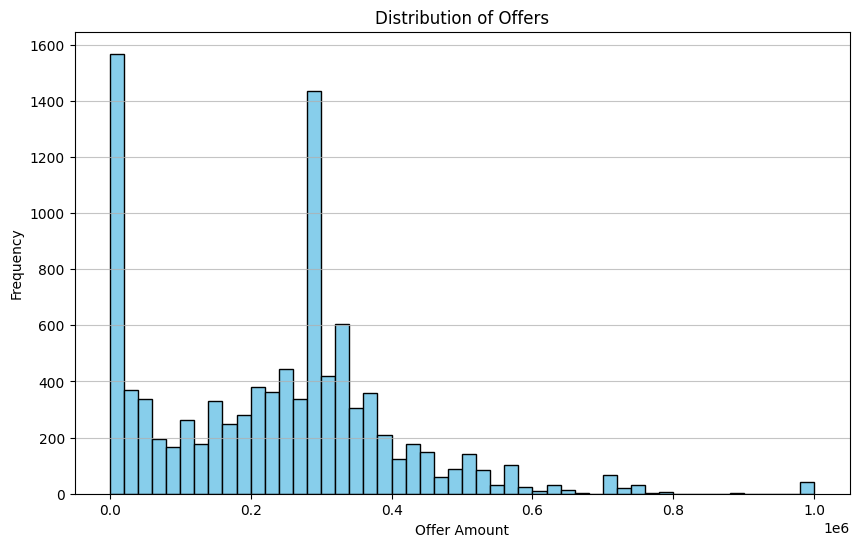

In [10]:
# Offer amount histogram

# Convert the Spark DataFrame to Pandas DataFrame for plotting
pdf_trial_results = sdf_trial_results.toPandas()

# Plotting using Matplotlib
plt.figure(figsize=(10, 6))
plt.hist(pdf_trial_results['offer'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Offers')
plt.xlabel('Offer Amount (USD)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

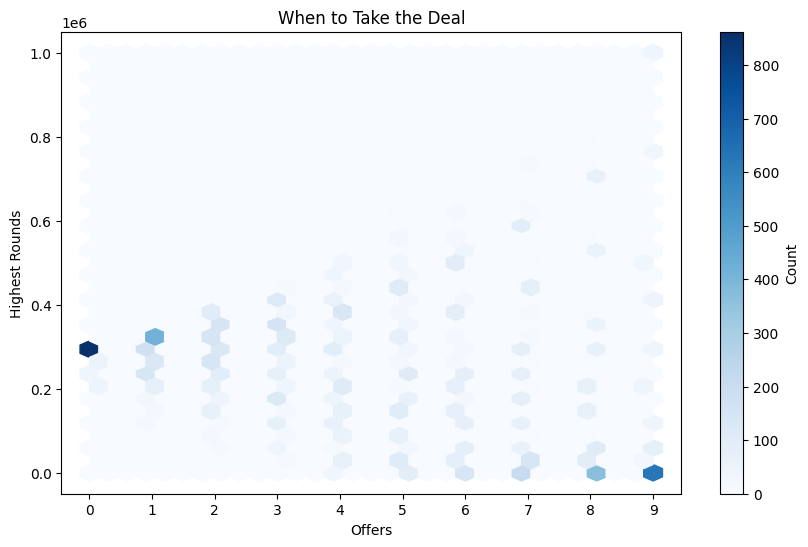

In [12]:
# Highest offer by round heatmap

# Convert Spark DataFrame to Pandas DataFrame for visualization
pdf_trial_highest_results = sdf_trial_highest_results.toPandas()

# Visualize using Matplotlib
plt.figure(figsize=(10, 6))
plt.hexbin(pdf_trial_highest_results['highest_round'], pdf_trial_highest_results['offer'], gridsize=30, cmap='Blues')
plt.colorbar(label='Count')
plt.xlabel('Offers')
plt.ylabel('Highest Rounds')
plt.title('When to take the deal')
plt.show()

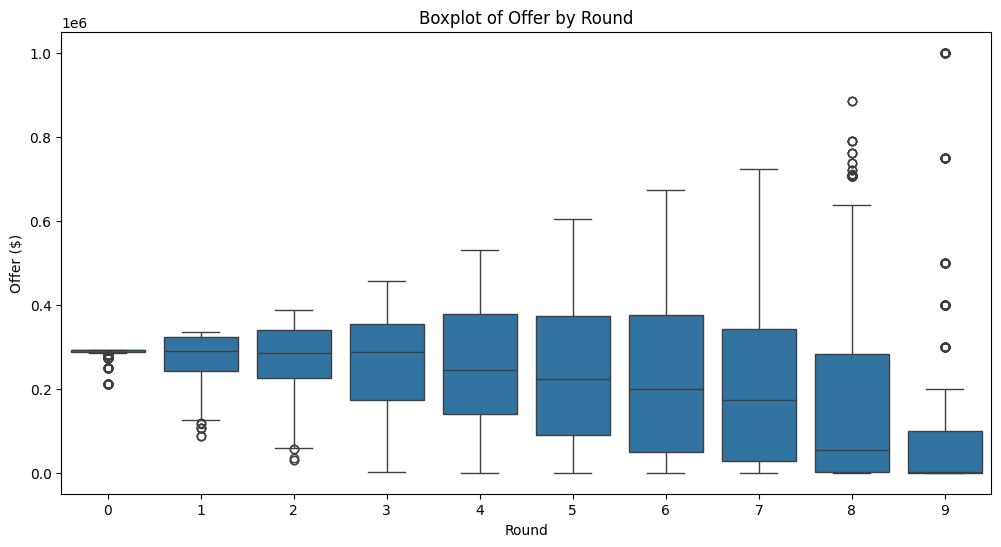

In [15]:
# Offer by Round Boxplot

# Convert Spark DataFrame to Pandas DataFrame for plotting
pdf_trial_results = sdf_trial_results.toPandas()

# Create a boxplot of offer by round
plt.figure(figsize=(12, 6))
plt.title('Total distribution of offers by round')
sns.boxplot(x='round', y='offer', data=pdf_trial_results)
plt.xlabel('Round Number')
plt.ylabel('Offer (USD)')
plt.show()

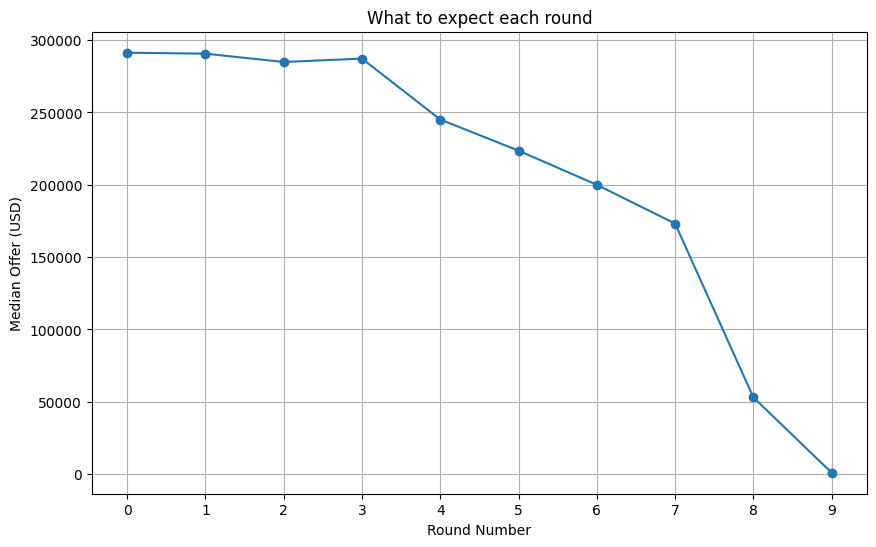

In [17]:
# Median Offer by Round

# Calculate median offer by round
sdf_median_offer_by_round = sdf_trial_results.groupBy('round').agg(F.expr('percentile_approx(offer, 0.5)').alias('median_offer'))

# Convert to Pandas DataFrame for plotting
pdf_median_offer_by_round = sdf_median_offer_by_round.toPandas()
pdf_median_offer_by_round.sort_values('round', inplace=True)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(pdf_median_offer_by_round['round'], pdf_median_offer_by_round['median_offer'], marker='o')
plt.title('What to expect each round')
plt.xlabel('Round Number')
plt.ylabel('Median Offer (USD)')
plt.grid(True)
plt.show()